In [4]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits
import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
import tensorflow.keras.backend as K
print(tf.__version__)

from scipy.io import readsav

import matplotlib as mpl

2.1.0


In [5]:
# Common arameters for the Figures
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}


def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    print(hdul.header)
    return spectrum 


def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances

def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec

def plot_spec_profile_comparison_fig(ax_object, wavescale, profile_FP1, profile_FP2, 
                                     profile_inferred, fSizeLegend, fSizeAxisLabel, fSizeTicks):
    
    ax_object.plot(wavescale, profile_FP1, 'g.--', label='Convolved spectrum')
    ax_object.plot(wavescale, profile_FP2, 'b.--', label='Original spectrum')
    ax_object.plot(wavescale,profile_inferred,'k.--',label = 'Inferred spectrum')
    ax_object.legend(fontsize=fSizeLegend)
    ax_object.xaxis.set_tick_params(labelsize=fSizeTicks)
    ax_object.yaxis.set_tick_params(labelsize=fSizeTicks)
    ax_object.set_ylabel('Normalized Intensity', fontsize=fSizeAxisLabel)
    ax_object.set_xlabel('Wavelength, $\AA$', fontsize=fSizeAxisLabel)
    ax_object.grid(alpha=0.5)

def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250,figsize=(8,6))
    #plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='Convolved spectrum')
    plt.plot(wavescale,profile_FP2,'b.--',label='Original spectrum')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred spectrum')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.grid(alpha=0.5)
    plt.savefig('Figures/Comparison_FISS.png',transparent=True)
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(dlambda,lambda_0,Nlambda,FPnum,wavelength):
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

def customLoss(yTrue,yPred):
    weights1 = K.constant(weights)
    return K.mean(K.square(yTrue-yPred)*weights1)

def customLoss1(yTrue,yPred):
    weights11 = K.constant(weights[0:40])
    return K.mean(K.square(yTrue-yPred)*weights11)

### Figure 1 - convolved spectral profile (a) and (b)/(c) are the IBIS images 

In [6]:
sizeX = 968
sizeY = 968


cutoutY = 100

caData = load_spectral_profiles('','FISS_20160622_175412_B1.fts')
caSpectralRes = 0.0256741359106
Nlambda_ca = caData.shape[2]
Nx_ca      = caData.shape[0]
Ny_ca      = caData.shape[1]
caConvolved = np.zeros((Nx_ca,Ny_ca,502))
TProfile = produce_FP_transmission_peak(caSpectralRes,0,Nlambda_ca,2,6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved[ii,jj,:] = np.convolve(caData[ii,jj,:],TProfile,mode='same')


dim1 = 15
dim2 = 17

vmin_a = 0.01
vmax_a = 0.4
waveCut0 = 30
waveCut1 = 60
waveNumd = waveCut1 - waveCut0

indices = radial_dist(sizeX-cutoutY, sizeY)

indices = indices / max(indices.flatten())

spec1 = (load_spectral_profiles('', 'even_ca_1fp.fits'))[:, cutoutY:, ]

waveNum  = (spec1.shape)[0]
spec1 = np.reshape(spec1,(waveNum, (sizeX-cutoutY) * sizeY))
spec1 = np.swapaxes(spec1, 0, 1)

spec2 = (load_spectral_profiles('', 'even_ca_2fp.fits'))[:, cutoutY:, :]

spec2 = np.reshape(spec2,(waveNum,(sizeX-cutoutY)*sizeY))
spec2 = np.swapaxes(spec2,0,1)
train_set1 = spec1[:,waveCut0:waveCut1]
truth_set1 = spec2[:,waveCut0:waveCut1]


cont_train = np.mean((train_set1[:, 3] + train_set1[:, -3]))
cont_truth = np.mean((truth_set1[:, 3] + truth_set1[:, -3]))

for ii in range(train_set1.shape[0]):
    train_set1[ii,:] = train_set1[ii, :] / 10000
    truth_set1[ii,:] = truth_set1[ii, :] / 10000

train_set = np.zeros(((sizeX-cutoutY) * sizeY,1, (waveNumd)))
truth_set = np.zeros(((sizeX-cutoutY) * sizeY, (waveNumd)))

train_set[:, 0, 0:(waveNumd)] = train_set1
#train_set[:,0,(waveNumd)]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set, 1, 2))


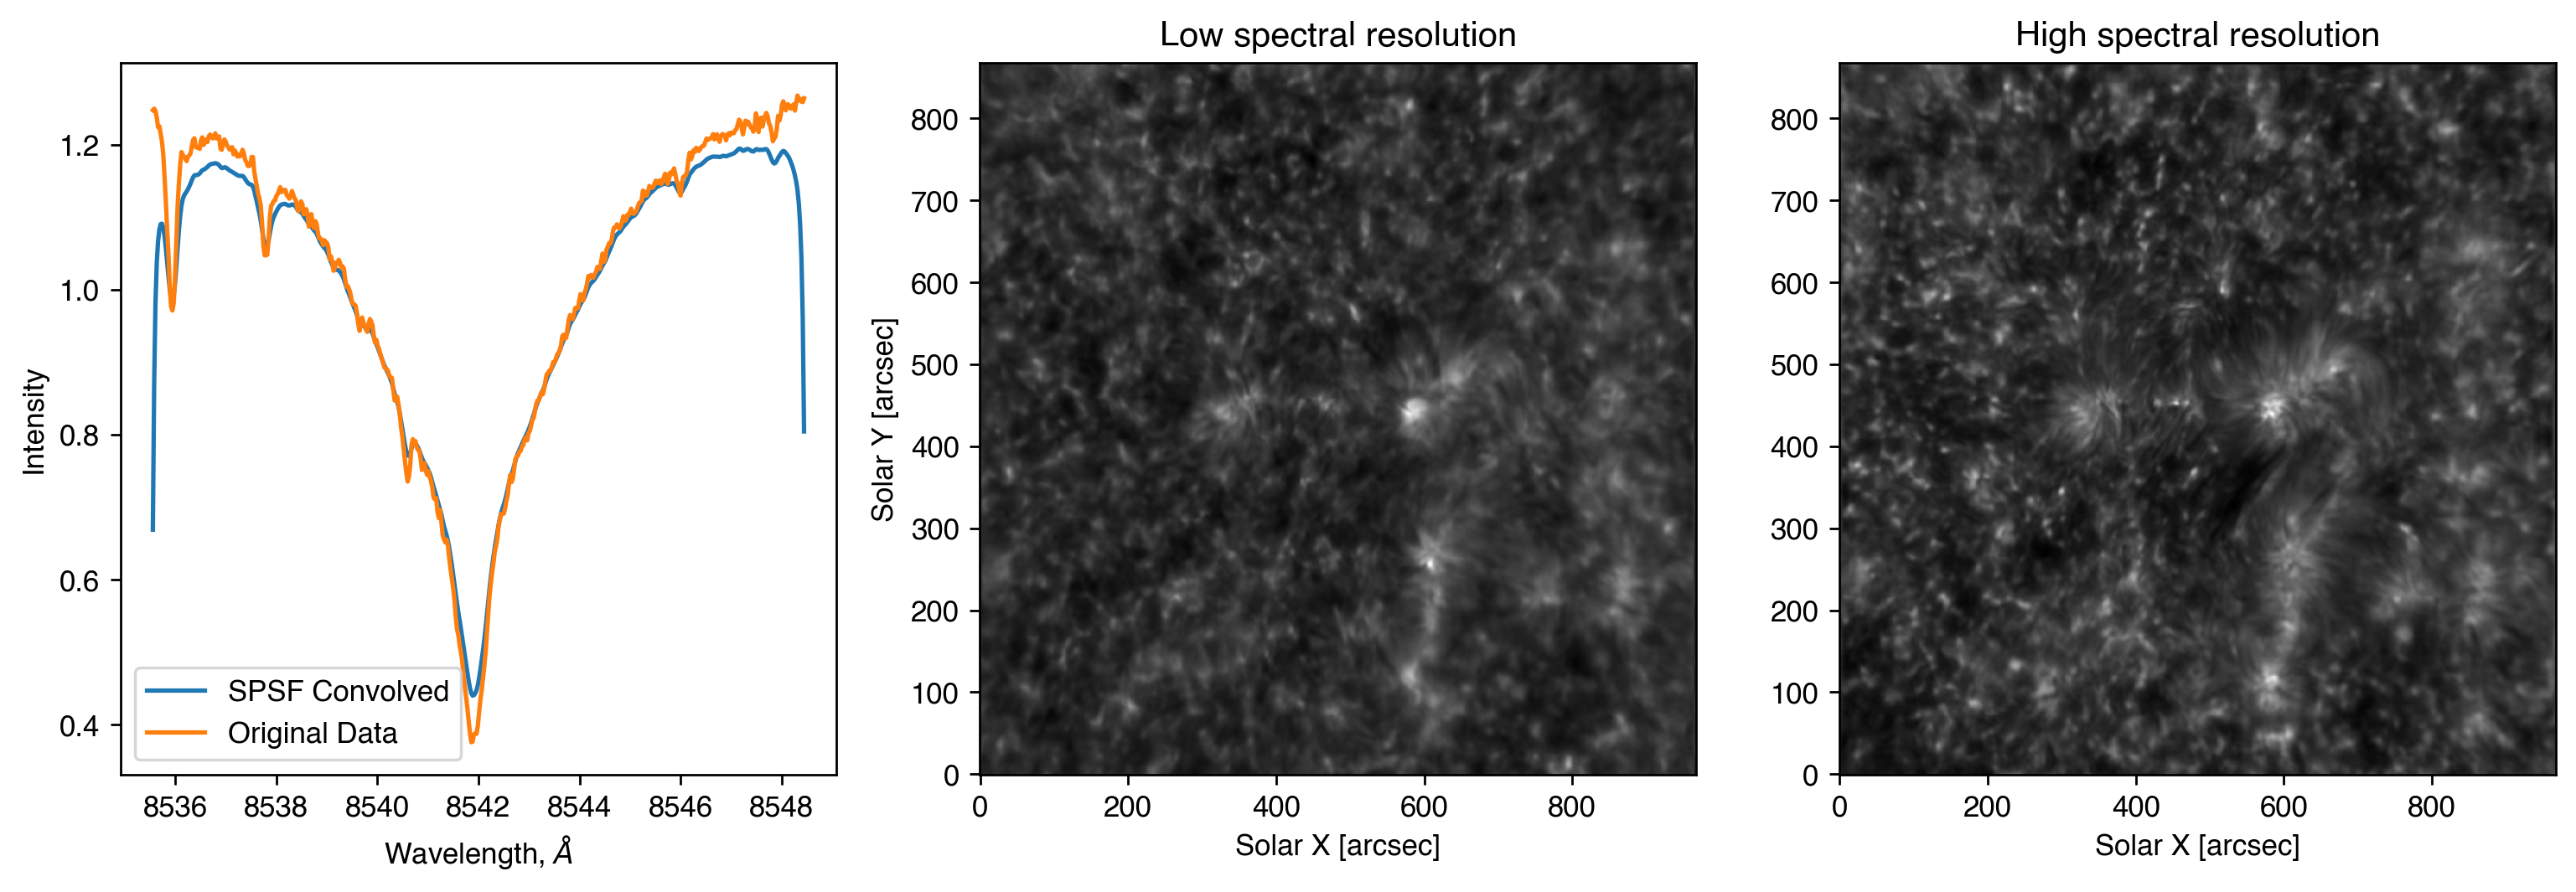

In [7]:
figure, ax = plt.subplots(1, 3)
figure.set_dpi(250)
figure.set_size_inches(15, 4.5)

norm   = 6000
wave   = np.linspace(caSpectralRes * 502/2, caSpectralRes * 502/ (-2), num=502) + 8542

ax[0].plot(wave , caConvolved[80, 20, :] / norm, label='SPSF Convolved')
ax[0].plot(wave, caData[80, 20, :] / norm, label='Original Data')
ax[0].set_xlabel('Wavelength, $\\AA$', **csfont)
ax[0].set_ylabel('Intensity', **csfont)
ax[0].set_adjustable("box")
ax[0].legend()
#ax[0].set_xlim(8537.5, 8546.5)
#ax[0].set_ylim(.2, 1.4)

ax[1].set_title('Low spectral resolution')

im0 = ax[1].imshow(np.reshape(np.mean(train_set[:, dim1:dim2, 0], axis=1),
                              (sizeX-cutoutY,sizeY)), origin='lower', cmap='gray', aspect='auto')
# ax[1].set_xlim(0, 1000)
# ax[1].set_ylim(0, 1000)
ax[1].set_ylabel('Solar Y [arcsec]', **csfont)
ax[1].set_xlabel('Solar X [arcsec]', **csfont)
                   

ax[2].set_title('High spectral resolution')
im2 = ax[2].imshow(np.reshape(np.mean(truth_set[:, dim1:dim2], axis=1), 
                              (sizeX-cutoutY, sizeY)), origin='lower', cmap='gray', aspect='auto')
ax[2].set_xlabel('Solar X [arcsec]', **csfont)
 
plt.savefig('Figures/Fig_1.png', transparent = True)
plt.show()

## Figure 2 -- Results from the FISS data

In [8]:
caData = load_spectral_profiles('','FISS_20160622_175412_B1.fts')
caSpectralRes = 0.0256741359106

fSizeAxisLabel = 8

cont_index = 1
core_index = 256

a = np.load('Fig2_2_data.npz') 

dl               = a['arr_0']
caSpectralRes    = a['arr_1']
caData_norm      = a['arr_2']
caData_Conv_norm = a['arr_3']
prevNum          = a['arr_4']
prevNumy         = a['arr_5']
res              = a['arr_6']
wavescale        = a['arr_7']

b = np.load('Fig2_3.npz')
print(b.files)
caData_test1 = b['arr_0']
norm_conv = b['arr_1']
predict = b['arr_2']
caConvolved_test1 = b['arr_3']
wavex = b['arr_4']

['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4']


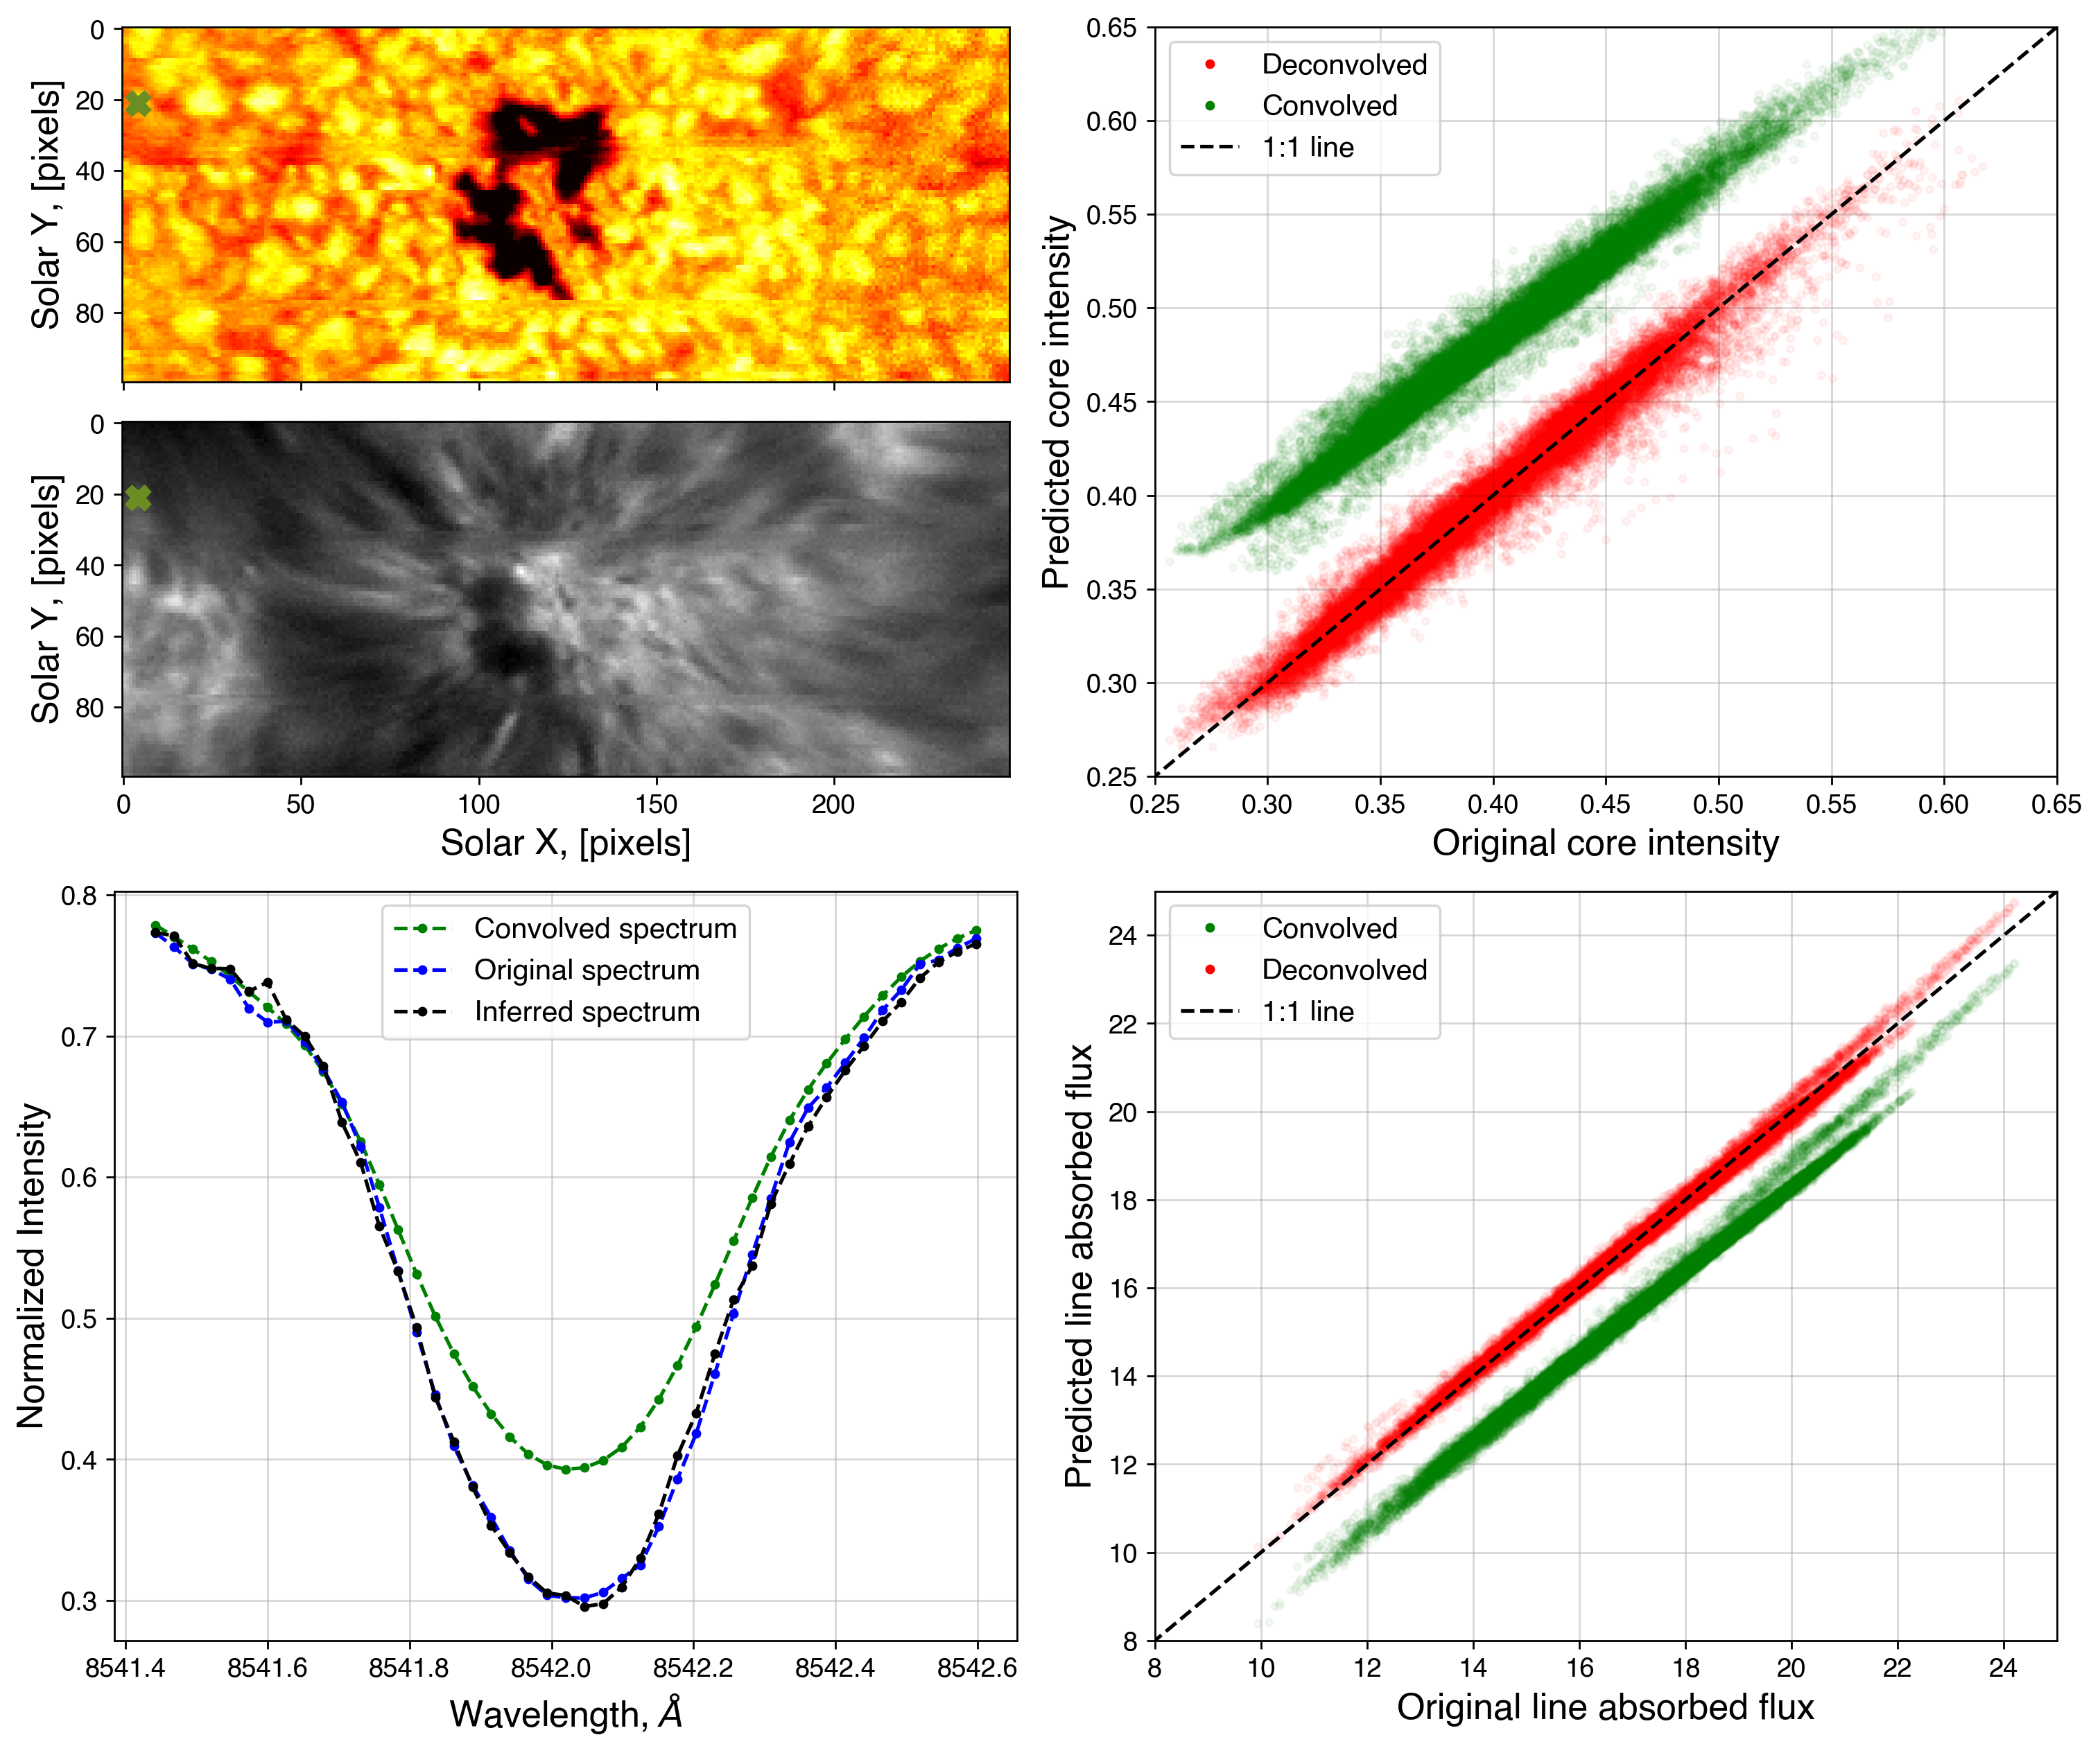

In [9]:
figure2 = plt.figure(constrained_layout=True)
figure2.set_size_inches(12, 10)
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=figure2)
figure2.set_dpi(250)

fSizeAxisLabel = 15
fSizeLegend    = 12
fSizeTicks     = 11

star_x = 4
star_y = 21
star_color = 'olivedrab'

f2_ax11 = figure2.add_subplot(spec[0, 0:2])
f2_ax12 = figure2.add_subplot(spec[1, 0:2])
f2_ax2 = figure2.add_subplot(spec[2:, 0:2])
f2_ax3 = figure2.add_subplot(spec[0:2, 2:])
f2_ax4 = figure2.add_subplot(spec[2:, 2:])

axis = [f2_ax11, f2_ax12, f2_ax2, f2_ax3, f2_ax4]

    
# f2_ax11 -- Continuum image
f2_ax11.imshow(caData[:, :, cont_index], cmap='hot',
               vmax=np.amax(caData[:, :, cont_index]),
               vmin=np.amin(caData[:, :, cont_index]) * 1.3)
f2_ax11.plot(star_x, star_y, color=star_color, marker='X', markersize=10)
f2_ax11.set_xticklabels([])
f2_ax11.set_ylabel('Solar Y, [pixels]', fontsize = fSizeAxisLabel)

# f2_ax12 -- Ca II 8542 Å line core image
f2_ax12.imshow(caData[:, :, core_index], cmap='gray',
               vmax=np.amax(caData[:, :, core_index]),
               vmin=np.amin(caData[:, :, core_index]) *1.)
f2_ax12.plot(star_x, star_y, color=star_color, marker='X', markersize=10)
f2_ax12.set_xlabel('Solar X, [pixels]', fontsize = fSizeAxisLabel)
f2_ax12.set_ylabel('Solar Y, [pixels]', fontsize = fSizeAxisLabel)

# f2_ax2 -- Quality of the fit plot

plot_spec_profile_comparison_fig(f2_ax2, wavescale, caData_Conv_norm[prevNum, prevNumy, :],
                             caData_norm[prevNum, prevNumy, :], res[0, :], fSizeLegend,
                                fSizeAxisLabel, fSizeTicks)

# f2_ax3  -- Correlation for the recovered intensity

f2_ax3.set_xlim(0.25, 0.65)
f2_ax3.set_ylim(0.25, 0.65)

f2_ax3.plot(np.amin(caData_test1/norm_conv, axis=1), np.amin(predict, axis=1), 'r.',
            alpha=0.042)
f2_ax3.plot(0,0,'r.',label='Deconvolved')
f2_ax3.plot(np.amin(caData_test1/norm_conv,axis=1), np.amin(caConvolved_test1/norm_conv,axis=1)
            , 'g.', alpha=0.042)
f2_ax3.plot(0, 0, 'g.', label='Convolved')
f2_ax3.plot(wavex, wavex, 'k--', label='1:1 line')
f2_ax3.set_xlabel('Original core intensity', **csfont, fontsize = fSizeAxisLabel)
f2_ax3.set_ylabel('Predicted core intensity', **csfont, fontsize = fSizeAxisLabel)
f2_ax3.legend(fontsize=fSizeLegend)
f2_ax3.grid(alpha=0.5)

# f2_ax4 -- Correlation for the recovered width

wavex = np.linspace(0,200,num=1000)

f2_ax4.plot(45-np.sum(caData_test1/norm_conv,axis=1), 45-np.sum(predict,axis=1),
            'r.', alpha=0.042)

f2_ax4.plot(45 - np.sum(caData_test1/norm_conv,axis=1),
            45 - np.sum(caConvolved_test1/norm_conv,axis=1), 'g.', alpha=0.042)

f2_ax4.plot(0, 0, 'g.', label='Convolved')
f2_ax4.plot(0, 0, 'r.', label='Deconvolved')
f2_ax4.plot(wavex, wavex, 'k--', label='1:1 line')
f2_ax4.set_xlim(8, 25)
f2_ax4.set_ylim(8, 25)
f2_ax4.set_xlabel('Original line absorbed flux',**csfont, fontsize = fSizeAxisLabel)
f2_ax4.set_ylabel('Predicted line absorbed flux',**csfont, fontsize = fSizeAxisLabel)
f2_ax4.legend(fontsize=fSizeLegend)
f2_ax4.grid(alpha=0.5)

for el in axis:
    el.xaxis.set_tick_params(labelsize=fSizeTicks)
    el.yaxis.set_tick_params(labelsize=fSizeTicks)

figure2.savefig('Fig_2.png')

plt.show()

## Figure 3 -- Results from IBIS data

In [44]:
a = np.load('Fig3_2.npz')

wavex          = a["wavex"]
min_I_predict  = a["min_I_predict"]
min_I_train_ML = a["min_I_train_ML"]
min_I_truth_ML = a["min_I_truth_ML"]

b = np.load("Fig_3_1.npz")

wave = b["wave"]
fp1  = b["fp1"]
fp2  = b["fp2"]
pf_f = b["pf_f"] 

c = np.load('Fig_3_3.npz')
H      = c["H"]
xedges = c["yedges"]
yedges = c["yedges"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


AttributeError: 'AxesSubplot' object has no attribute 'get_array'

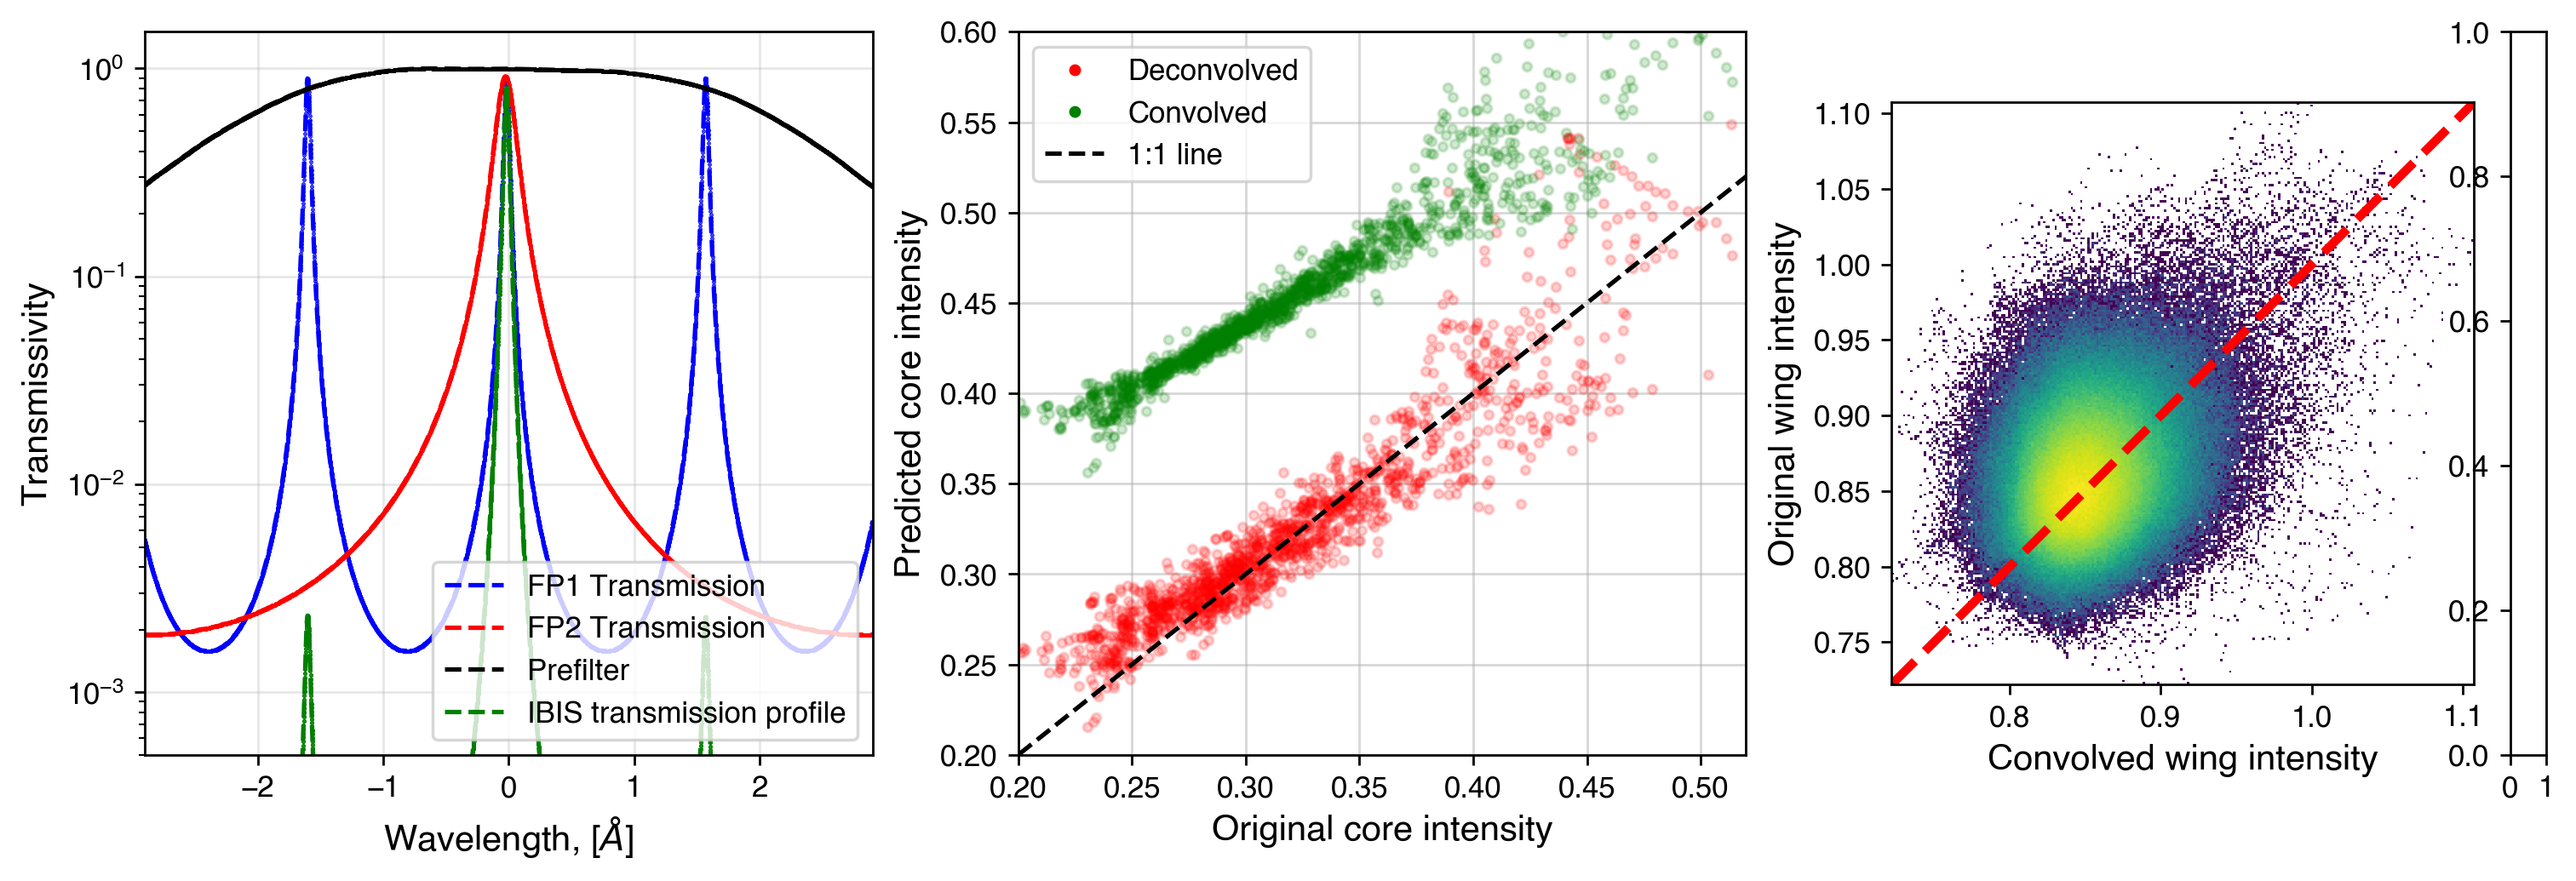

In [66]:
figure, ax = plt.subplots(1, 3)
figure.set_dpi(250)
figure.set_size_inches(15, 4.5)
alpha1 = 0.18
fSizeAxisLabel = 12

markersize1 = .75

ax[0].plot(wave, fp1, 'b.--', label='FP1 Transmission', markersize=markersize1)
ax[0].plot(wave, fp2, 'r.--', label='FP2 Transmission', markersize=markersize1)
ax[0].plot(wave, pf_f,'k.--',label='Prefilter', markersize=markersize1)
ax[0].plot(wave, fp1*fp2*pf_f, 'g.--',
      markersize=1, label='IBIS transmission profile')
ax[0].legend(loc='lower right')
ax[0].set_yscale('log')
ax[0].set_ylabel('Transmissivity', fontsize = fSizeAxisLabel)
ax[0].set_ylim(5e-4, 1.5)
ax[0].set_xlabel('Wavelength, [$\\AA$]', fontsize = fSizeAxisLabel)
ax[0].set_xlim(-2.9, 2.9)
ax[0].grid(alpha=0.3)


ax[1].plot(min_I_truth_ML, min_I_predict, 'r.', alpha=alpha1)
ax[1].plot(0, 0, 'r.', label='Deconvolved')

ax[1].plot(min_I_truth_ML, min_I_train_ML, 'g.', alpha=alpha1)
ax[1].plot(0,0, 'g.', label='Convolved')
ax[1].plot(wavex,wavex,'k--', label='1:1 line')

ax[1].set_xlabel('Original core intensity', fontsize = fSizeAxisLabel)
ax[1].set_ylabel('Predicted core intensity', fontsize = fSizeAxisLabel)
ax[1].legend()
ax[1].set_xlim(.2, .52)
ax[1].set_ylim(0.2, .6)
ax[1].grid(alpha=0.5)

xlims = np.linspace(xedges[0], xedges[-1], num=100)
ylims = xlims.copy()
ax[2].imshow(np.log(H), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           interpolation='nearest', origin='low')
ax[2].plot(xlims, ylims, '--', color='red', linewidth = 3)
ax[2].set_xlabel('Convolved wing intensity', fontsize = fSizeAxisLabel)
ax[2].set_ylabel('Original wing intensity', fontsize = fSizeAxisLabel)
plt.colorbar(ax[2])

plt.tight_layout()
plt.savefig('Figures/Fig_3.png')
plt.show()

## Figure 4 -- Multiplexing Figure